In [ ]:
import pandas as pd

df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
print(df.shape)
print(df['Class'].value_counts())

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
print(df.head())
print(df.columns.tolist())
print(df.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

0


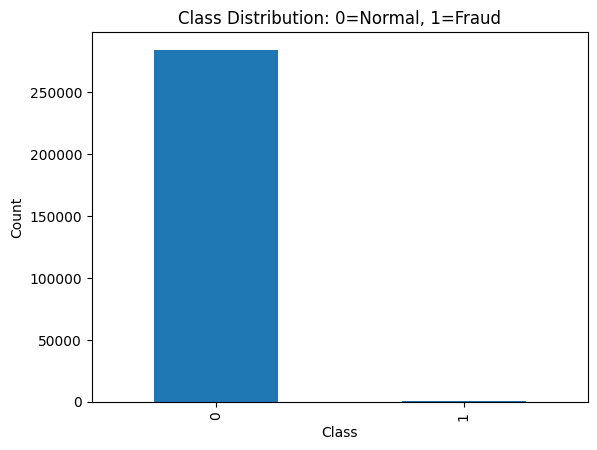

Fraud percentage: 0.173%


In [ ]:
import matplotlib.pyplot as plt

# Check missing values
print(df.isnull().sum().sum())

# Visualize the class imbalance
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution: 0=Normal, 1=Fraud')
plt.ylabel('Count')
plt.show()

# Show the imbalance as percentage
fraud_pct = df['Class'].sum() / len(df) * 100
print(f'Fraud percentage: {fraud_pct:.3f}%')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Scale Time and Amount (V1-V28 are already scaled by PCA)
scaler = StandardScaler()
X['Time'] = scaler.fit_transform(X[['Time']])
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Fraud in train: {y_train.sum()}')
print(f'Fraud in test: {y_test.sum()}')



Training set: (227845, 30)
Test set: (56962, 30)
Fraud in train: 394
Fraud in test: 98


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data ONLY
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f'Before SMOTE: {y_train.value_counts().to_dict()}')
print(f'After SMOTE: {pd.Series(y_train_balanced).value_counts().to_dict()}')

Before SMOTE: {0: 227451, 1: 394}
After SMOTE: {0: 227451, 1: 227451}


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(30,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 4.4094e-04
Epoch 2/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 6.5424e-04
Epoch 3/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 4/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 9.4385e-04
Epoch 5/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 5.1915e-04
Epoch 6/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9988 - val_loss: 0.0025
Epoch 7/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 6.4866e-04
Epoch 8/20
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accura

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Predict on ORIGINAL imbalanced test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:')
print(cm)

# AUC-ROC score
auc = roc_auc_score(y_test, y_pred_prob)
print(f'\nAUC-ROC: {auc:.4f}')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.75      0.82      0.78        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56838    26]
 [   18    80]]

AUC-ROC: 0.9740


In [ ]:
# Try different thresholds
for threshold in [0.5, 0.4, 0.3, 0.2, 0.1]:
  y_pred_new = (y_pred_prob > threshold).astype(int).flatten()
  cm = confusion_matrix(y_test, y_pred_new)
  recall = cm[1][1] / (cm[1][0] + cm[1][1])
  precision = cm[1][1] / (cm[0][1] + cm[1][1])
  false_alarms = cm[0][1]
  missed_frauds = cm[1][0]
  print(f'Threshold: {threshold} | Recall: {recall:.3f} | Precision: {precision:.3f} | Missed Frauds: {missed_frauds} | Flase Alarms: {false_alarms}')


Threshold: 0.5 | Recall: 0.816 | Precision: 0.755 | Missed Frauds: 18 | Flase Alarms: 26
Threshold: 0.4 | Recall: 0.827 | Precision: 0.743 | Missed Frauds: 17 | Flase Alarms: 28
Threshold: 0.3 | Recall: 0.827 | Precision: 0.730 | Missed Frauds: 17 | Flase Alarms: 30
Threshold: 0.2 | Recall: 0.827 | Precision: 0.711 | Missed Frauds: 17 | Flase Alarms: 33
Threshold: 0.1 | Recall: 0.827 | Precision: 0.669 | Missed Frauds: 17 | Flase Alarms: 40


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_balanced, y_train_balanced)
lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:,1]
lr_auc = roc_auc_score(y_test, lr_prob)
lr_recall = classification_report(y_test, lr_pred, output_dict=True)['1']['recall']

# Random Forest - fewer trees, faster
rf = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
rf.fit(X_train_balanced, y_train_balanced)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_prob)
rf_recall = classification_report(y_test, rf_pred, output_dict=True)['1']['recall']

# Deep Learning (already calculated)
dl_recall = 80/98
dl_auc = auc

print(f'Logistic Regression | Recall: {lr_recall:.3f} | AUC: {lr_auc:.4f}')
print(f'Random Forest       | Recall: {rf_recall:.3f} | AUC: {rf_auc:.4f}')
print(f'Deep Learning       | Recall: {dl_recall:.3f} | AUC: {dl_auc:.4f}')

Logistic Regression | Recall: 0.918 | AUC: 0.9698
Random Forest       | Recall: 0.816 | AUC: 0.9621
Deep Learning       | Recall: 0.816 | AUC: 0.9740


In [ ]:
print(f'LR flagged as fraud: {lr_pred.sum()}')
print(f'RF flagged as fraud: {rf_pred.sum()}')
print(f'DL flagged as fraud: {y_pred.sum()}')
print(f'Actual frauds: {y_test.sum()}')

LR flagged as fraud: 1548
RF flagged as fraud: 94
DL flagged as fraud: 106
Actual frauds: 98


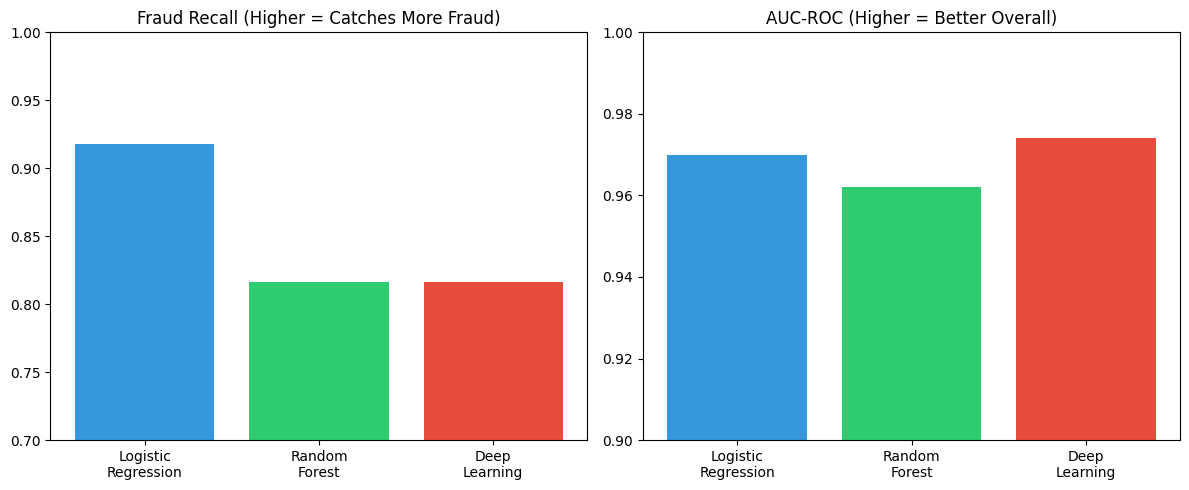

In [ ]:
import matplotlib.pyplot as plt

# Model comparison bar chart
models = ['Logistic\nRegression', 'Random\nForest', 'Deep\nLearning']
recalls = [0.918, 0.816, 0.816]
aucs = [0.9698, 0.9621, 0.9740]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(models, recalls, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_title('Fraud Recall (Higher = Catches More Fraud)')
ax1.set_ylim(0.7, 1.0)

ax2.bar(models, aucs, color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_title('AUC-ROC (Higher = Better Overall)')
ax2.set_ylim(0.9, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
model.save('fraud_model.h5')
print("Model Saved")

Model Saved


In [ ]:
%%writefile app.Py
import streamlit as st
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('fraud_model.h5')

st.title('Real-Time Fraud Detection System')
st.write('Enter transaction details to get fraud probability')

amount = st.number_input('Transaction Amount (€)', min_value=0.0, max_value=30000.0, value=100.0)
time = st.number_input('Time (seconds since first transaction)', min_value=0, max_value=180000, value=50000)

st.subheader('PCA Features (V1-V28)')
st.write('These are anonymized features from the original transaction data')

v_features = []
cols = st.columns(4)
for i in range(28):
    with cols[i % 4]:
        v = st.number_input(f'V{i+1}', value=0.0, format='%.4f', key=f'{i+1}')
        v_features.append(v)

if st.button('Detect Fraud', type='primary'):
    features = np.array([[time] + v_features + [amount]])
    prediction = model.predict(features, verbose=0)
    probability = prediction[0][0]

    if probabability > 0.5:
        st.error(f' FRAUD DETECTED - Probability: {probability:.2%}')
    elif probability > 0.3:
        st.warning(f' SUSPICIOUS - Probability: {probability:.2%}')
    else:
        st.success(f' NORMAL - Fraud Probability: {probability:.2%}')

    st.progress(min(float(probability), 1.0))

Writing app.Py


In [ ]:
from google.colab import files
files.download('fraud_model.h5')
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: app.py

In [ ]:
import os
print(os.listdir())

['.config', 'fraud_model.h5', 'app.Py', 'sample_data']


In [ ]:
import os
os.rename('app.Py', 'app.py')

In [ ]:
from google.colab import files
files.download('fraud_model.h5')
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tf2onnx onnxruntime

import tf2onnx
import onnx

# Convert TensorFlow model to ONNX format
import subprocess
subprocess.run(['python', '-m', 'tf2onnx.convert',
                '--saved-model', '.',
                '--output', 'fraud_model.onnx',
                '--opset', '13'], check=False)

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.6
    Uninstalling protobuf-5.29.6:
      Successfully uninstalled protobuf-5.29.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.38.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
y

CompletedProcess(args=['python', '-m', 'tf2onnx.convert', '--saved-model', '.', '--output', 'fraud_model.onnx', '--opset', '13'], returncode=1)

In [ ]:
# Save model weights as a simpler format
import json
import numpy as np

weights = []
for layer in model.layers:
    layer_weights = layer.get_weights()
    if layer_weights:
        weights.append({
            'weights': layer_weights[0].tolist(),
            'biases': layer_weights[1].tolist()
        })

with open('model_weights.json', 'w') as f:
    json.dump(weights, f)

print(f"Saved {len(weights)} layers")

Saved 4 layers


In [ ]:
from google.colab import files
files.download('model_weights.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import json

# Load model weights
with open('model_weights.json', 'r') as f:
    layers = json.load(f)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def predict(features):
    x = features
    for i, layer in enumerate(layers):
        weights = np.array(layer['weights'])
        biases = np.array(layer['biases'])
        x = np.dot(x, weights) + biases
        if i < len(layers) - 1:
            x = relu(x)
        else:
            x = sigmoid(x)
    return x[0][0]

st.title('Real-Time Fraud Detection System')
st.write('Enter transaction details to get fraud probability')

amount = st.number_input('Transaction Amount', min_value=0.0, max_value=30000.0, value=100.0)
time_val = st.number_input('Time (seconds)', min_value=0, max_value=180000, value=50000)

st.subheader('PCA Features (V1-V28)')

v_features = []
cols = st.columns(4)
for i in range(28):
    with cols[i % 4]:
        v = st.number_input(f'V{i+1}', value=0.0, format='%.4f', key=f'v{i+1}')
        v_features.append(v)

if st.button('Detect Fraud', type='primary'):
    features = np.array([[time_val] + v_features + [amount]])
    probability = predict(features)

    if probability > 0.5:
        st.error(f'FRAUD DETECTED - Probability: {probability:.2%}')
    elif probability > 0.3:
        st.warning(f'SUSPICIOUS - Probability: {probability:.2%}')
    else:
        st.success(f'NORMAL - Fraud Probability: {probability:.2%}')

    st.progress(min(float(probability), 1.0))

Overwriting app.py


In [ ]:
from google.colab import files
files.download('app.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get a real fraud transaction
fraud_example = df[df['Class'] == 1].iloc[0]
print("FRAUD EXAMPLE:")
print(f"Time: {fraud_example['Time']}")
print(f"Amount: {fraud_example['Amount']}")
for i in range(1, 29):
    print(f"V{i}: {fraud_example[f'V{i}']:.4f}")

print("\n")

# Get a real normal transaction
normal_example = df[df['Class'] == 0].iloc[0]
print("NORMAL EXAMPLE:")
print(f"Time: {normal_example['Time']}")
print(f"Amount: {normal_example['Amount']}")
for i in range(1, 29):
    print(f"V{i}: {normal_example[f'V{i}']:.4f}")

FRAUD EXAMPLE:
Time: 406.0
Amount: 0.0
V1: -2.3122
V2: 1.9520
V3: -1.6099
V4: 3.9979
V5: -0.5222
V6: -1.4265
V7: -2.5374
V8: 1.3917
V9: -2.7701
V10: -2.7723
V11: 3.2020
V12: -2.8999
V13: -0.5952
V14: -4.2893
V15: 0.3897
V16: -1.1407
V17: -2.8301
V18: -0.0168
V19: 0.4170
V20: 0.1269
V21: 0.5172
V22: -0.0350
V23: -0.4652
V24: 0.3202
V25: 0.0445
V26: 0.1778
V27: 0.2611
V28: -0.1433


NORMAL EXAMPLE:
Time: 0.0
Amount: 149.62
V1: -1.3598
V2: -0.0728
V3: 2.5363
V4: 1.3782
V5: -0.3383
V6: 0.4624
V7: 0.2396
V8: 0.0987
V9: 0.3638
V10: 0.0908
V11: -0.5516
V12: -0.6178
V13: -0.9914
V14: -0.3112
V15: 1.4682
V16: -0.4704
V17: 0.2080
V18: 0.0258
V19: 0.4040
V20: 0.2514
V21: -0.0183
V22: 0.2778
V23: -0.1105
V24: 0.0669
V25: 0.1285
V26: -0.1891
V27: 0.1336
V28: -0.0211


In [46]:
# Get real examples from the SCALED data
fraud_idx = y_test[y_test == 1].index[0]
normal_idx = y_test[y_test == 0].index[0]

print("NORMAL (scaled):")
print(list(X_test.loc[normal_idx].values))

print("\nFRAUD (scaled):")
print(list(X_test.loc[fraud_idx].values))

NORMAL (scaled):
[np.float64(1.3886887953406681), np.float64(-0.674466064578314), np.float64(1.40810501967799), np.float64(-1.11062205357093), np.float64(-1.32836577843066), np.float64(1.38899603254837), np.float64(-1.30843906707795), np.float64(1.88587890268717), np.float64(-0.614232966299775), np.float64(0.311652212453101), np.float64(0.65075700363522), np.float64(-0.857784661547805), np.float64(-0.229961445775592), np.float64(-0.19981700479103), np.float64(0.266371326329879), np.float64(-0.0465441684754424), np.float64(-0.741398089749789), np.float64(-0.605616644106022), np.float64(-0.39256818789208), np.float64(-0.162648311024695), np.float64(0.394321820843914), np.float64(0.0800842396026648), np.float64(0.810033595602455), np.float64(-0.224327230436412), np.float64(0.707899237446867), np.float64(-0.13583702273753), np.float64(0.0451021964988772), np.float64(0.533837219064273), np.float64(0.291319252625364), np.float64(-0.2612734105062506)]

FRAUD (scaled):
[np.float64(-0.796133965

In [47]:
normal_vals = list(X_test.loc[normal_idx].values)
fraud_vals = list(X_test.loc[fraud_idx].values)

print("NORMAL:")
print(str(normal_vals))
print("\nFRAUD:")
print(str(fraud_vals))

NORMAL:
[np.float64(1.3886887953406681), np.float64(-0.674466064578314), np.float64(1.40810501967799), np.float64(-1.11062205357093), np.float64(-1.32836577843066), np.float64(1.38899603254837), np.float64(-1.30843906707795), np.float64(1.88587890268717), np.float64(-0.614232966299775), np.float64(0.311652212453101), np.float64(0.65075700363522), np.float64(-0.857784661547805), np.float64(-0.229961445775592), np.float64(-0.19981700479103), np.float64(0.266371326329879), np.float64(-0.0465441684754424), np.float64(-0.741398089749789), np.float64(-0.605616644106022), np.float64(-0.39256818789208), np.float64(-0.162648311024695), np.float64(0.394321820843914), np.float64(0.0800842396026648), np.float64(0.810033595602455), np.float64(-0.224327230436412), np.float64(0.707899237446867), np.float64(-0.13583702273753), np.float64(0.0451021964988772), np.float64(0.533837219064273), np.float64(0.291319252625364), np.float64(-0.2612734105062506)]

FRAUD:
[np.float64(-0.7961339653941819), np.float

In [48]:
with open('examples.txt', 'w') as f:
    f.write("NORMAL:\n")
    f.write(str(list(X_test.loc[normal_idx].values)))
    f.write("\n\nFRAUD:\n")
    f.write(str(list(X_test.loc[fraud_idx].values)))

from google.colab import files
files.download('examples.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>